In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
# Convert the series into sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Dataset and DataLoader
class PriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=0.1)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.activation = nn.Sigmoid()

    def forward(self, input_seq, hidden_cell=None):
        """
        Predicts what the next value of the given Sequence will be
        Futher Work: Predict Several Time Steps ahead e.g. autoregressively by using an internal loop or by predicting a vector
        :param input_seq: 
        :param hidden_cell: 
        :return: 
        """
        if hidden_cell is None:
            # Initialize hidden and cell state
            h0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
            c0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
            hidden_cell = (h0, c0)
        lstm_out, (hn, cn) = self.lstm(input_seq, hidden_cell)
        # First input to the decoder is the first time step of the target
        lstm_out = lstm_out[:, -1, :].unsqueeze(1)  # (batch_size, 1, output_dim)
        predictions = self.linear(lstm_out.reshape(lstm_out.size(0), lstm_out.size(1)* lstm_out.size(2)))
        return self.activation(predictions), hn, cn  # Return the last prediction and Hidden State

In [3]:
# Load the dataset (assuming it's extracted)
data_path = 'data/european_wholesale_electricity_price_data_hourly/european_wholesale_electricity_price_data_hourly/Germany.csv'
df = pd.read_csv(data_path)

# Inspect the data structure
print(df.head())  # Ensure you understand the structure

# Preprocessing: focusing on the 'price' column as our target variable
prices = df['Price (EUR/MWhe)'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

SEQ_LENGTH = 256  # We will use 24 hours of data to predict the next hour
batch_size = 128
X, y = create_sequences(prices_scaled, SEQ_LENGTH)

# Split into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

train_dataset = PriceDataset(X_train, y_train)
val_dataset = PriceDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

   Country ISO3 Code       Datetime (UTC)     Datetime (Local)  \
0  Germany       DEU  2015-01-01 00:00:00  2015-01-01 01:00:00   
1  Germany       DEU  2015-01-01 01:00:00  2015-01-01 02:00:00   
2  Germany       DEU  2015-01-01 02:00:00  2015-01-01 03:00:00   
3  Germany       DEU  2015-01-01 03:00:00  2015-01-01 04:00:00   
4  Germany       DEU  2015-01-01 04:00:00  2015-01-01 05:00:00   

   Price (EUR/MWhe)  
0             17.93  
1             15.17  
2             16.38  
3             17.38  
4             16.38  


In [4]:
# Instantiate the model, loss function, and optimizer
model = LSTMModel(input_size=1, hidden_layer_size=128, output_size=1, num_layers=6)
# Check For GPU -> If available send model to it
device = ("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) 

loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters())
print(f"GPU Available: {torch.cuda.is_available()} (Use {device})")

GPU Available: True (Use cuda)


In [5]:
epochs = 5  # You can increase this based on available time and resources

for epoch in range(epochs):
    train_losses = []
    # Train Step
    model.train()
    for seq, labels in tqdm(train_loader):
        optimizer.zero_grad()
        
        y_pred, _, _ = model(seq.to(device))
        
        loss = loss_function(y_pred.to("cpu"), labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss)
    # Validation Step (When this doesn't drop anymore then it starts overfitting)
    model.eval()
    val_losses = []
    errors = []
    for seq, labels in tqdm(val_loader):
    
        y_pred, _, _ = model(seq.to(device))
        loss = loss_function(input=y_pred.to("cpu"), target=labels)
        error = root_mean_squared_error(y_pred=y_pred.detach().to("cpu"), y_true=labels)
        val_losses.append(loss)
        errors.append(error)
    print(f'Epoch {epoch+1}:\nTrain_Loss: {sum(train_losses)/len(train_losses)},\nVal_Loss: {sum(val_losses)/len(val_losses)}\nRMSE: {sum(errors)/len(errors)}')


print(f'Training completed.')

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 1:
Train_Loss: 0.0013092599110677838,
Val_Loss: 0.010840397328138351
RMSE: 0.07337536098156858


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 2:
Train_Loss: 0.000398547068471089,
Val_Loss: 0.0022619403898715973
RMSE: 0.03850174352057337


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 3:
Train_Loss: 0.00023021528613753617,
Val_Loss: 0.0014095684746280313
RMSE: 0.031057050744966258


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 4:
Train_Loss: 0.00011029556480934843,
Val_Loss: 0.0008013575570657849
RMSE: 0.021891335256427058


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 5:
Train_Loss: 6.0188289353391156e-05,
Val_Loss: 0.0007414428400807083
RMSE: 0.01988137473432919
Training completed.


# The loss and RMSE are quite small
- For that it is an absolute trivial LSTM it already performs quite well
- Reason: By time Series the reason for this is often that the next value is likely very similar to the last few values
- Meaning: If you make only minor (or no adjustments) at all to the last value you already have a really good forecast
- However: The Problem with this approach becomes salient if we forecast several time Steps at once

In [6]:
# Define a function to make autoregressive predictions using the trained model
def autoregressive_forecast(model, data, forecast_length, hidden_state=None):
    model.eval()  # Set the model to evaluation mode
    
    predictions = []
    input_seq = data.to(device) 
    
    for _ in range(forecast_length):
        # Forward pass through the model to predict the next step
        with torch.no_grad():
            y_pred, hn, cn = model(input_seq, None)
        
        # Store the prediction
        predictions.append(y_pred.item())
        
        # Update the input sequence (drop the first element and append the new prediction)
        input_seq = torch.cat((input_seq[:,1:,:], y_pred.unsqueeze(0)), dim=1)
    
    return predictions

def plot_forecast(forecast_length = 8):
    input_seq = prices_scaled[-(SEQ_LENGTH+forecast_length):-forecast_length]
    input_seq = torch.tensor(input_seq).float().unsqueeze(0)
    target = prices_scaled[-forecast_length-1:]  
    # Autoregressive prediction over the next 24 time steps
    autoregressive_predictions = autoregressive_forecast(model, input_seq, forecast_length=forecast_length, hidden_state=None)
    
    # Rescale the predictions back to original price scale
    pred = scaler.inverse_transform(np.array(autoregressive_predictions).reshape(-1, 1))
    target = scaler.inverse_transform(target)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(range(forecast_length), pred, label='Predicted (Autoregressive)', linestyle='--')
    plt.plot(range(forecast_length), target[1:], label='Actual (Test Set)', linestyle='-')
    plt.title('Autoregressive Forecast vs Actual Test Set Values')
    plt.xlabel('Time Step (Hour)')
    plt.ylabel('Electricity Price')
    plt.legend()
    plt.show()
    input_seq_rescaled = scaler.inverse_transform(input_seq.reshape(-1, 1))
    
    # Plot the input sequence, the forecasted values, and the actual test values
    plt.figure(figsize=(12, 6))
    
    # Plot input data
    plt.plot(range(SEQ_LENGTH), input_seq_rescaled, label='Input Sequence', linestyle='-')
    
    # Plot autoregressive forecast data
    plt.plot(range(SEQ_LENGTH, SEQ_LENGTH + forecast_length), pred, label='Predicted (Autoregressive)', linestyle='--')
    
    # Plot actual test data
    plt.plot(range(SEQ_LENGTH-1, SEQ_LENGTH + forecast_length), target, label='Actual (Test Set)', linestyle='-')
    
    plt.title('Input Data, Autoregressive Forecast, and Actual Test Set Values')
    plt.xlabel('Time Step (Hour)')
    plt.ylabel('Electricity Price')
    plt.legend()
    plt.show()

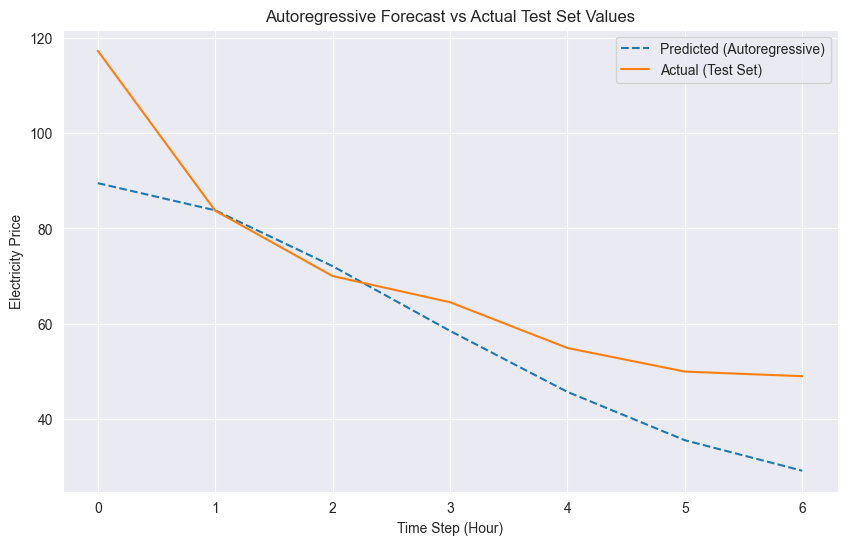

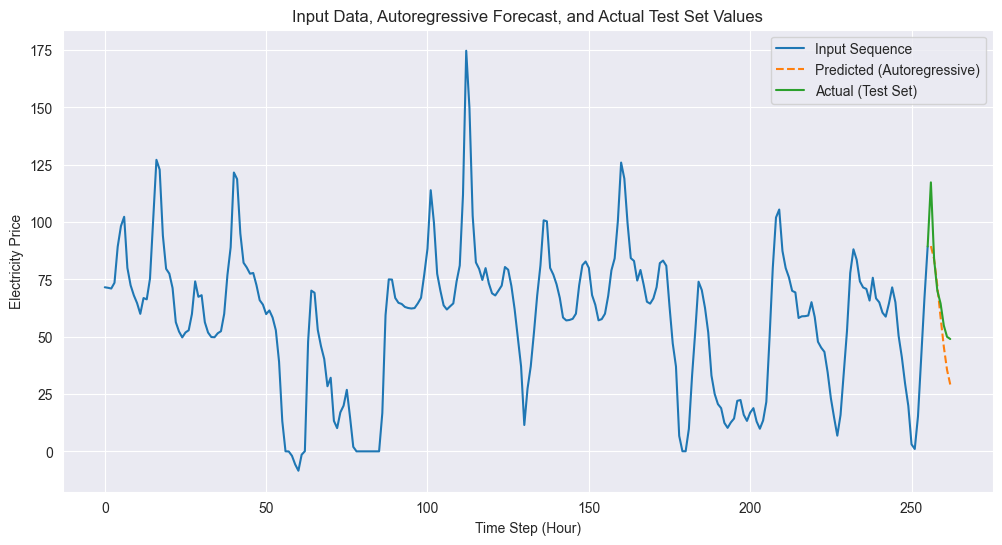

In [11]:
plot_forecast(7)

Seems pretty accurate
Let's look at a longer forecast

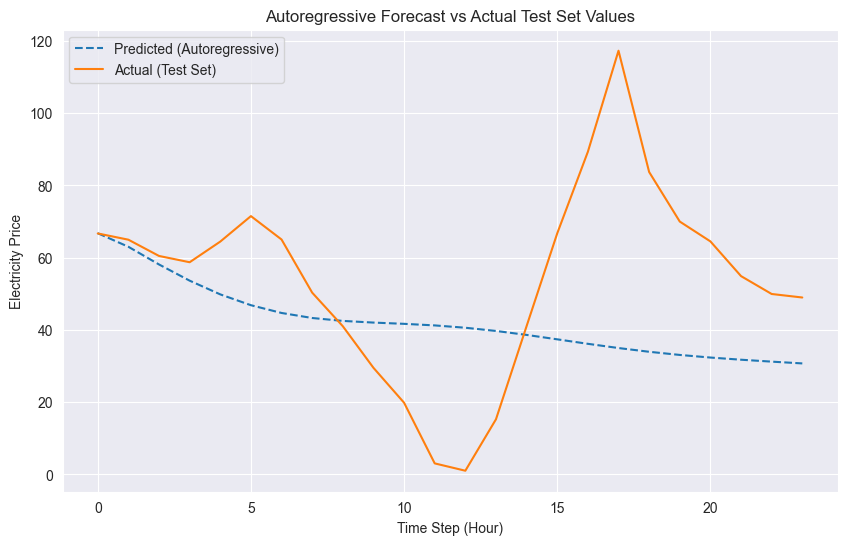

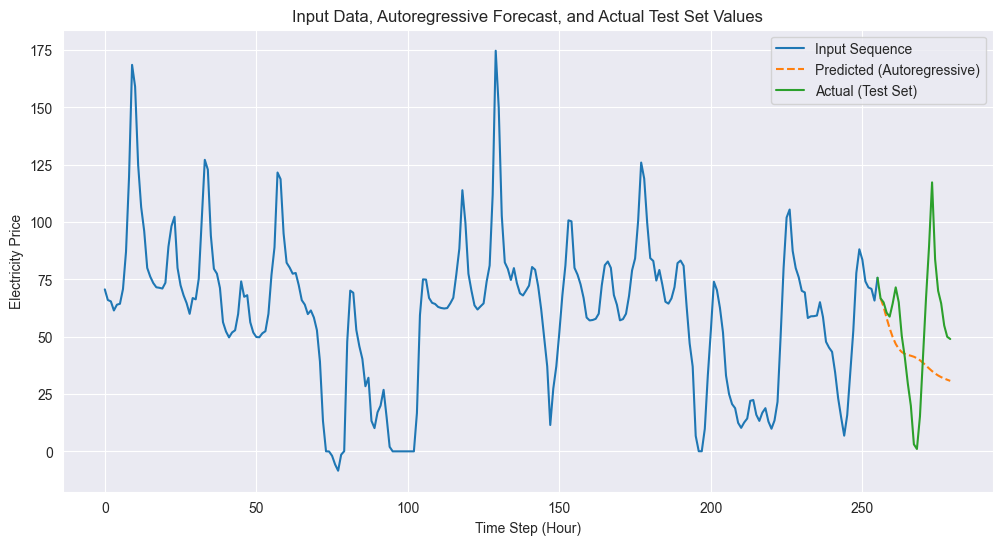

In [9]:
plot_forecast(24)

# This Forecast is much worse, likely due to:
- Harder Startpoint
- Regression to the mean (a typicall problem when using Vanilla LSTMs for Autoregressive Forecasting)
# LSTM don't pick up on the Season
- The first few forecasts of the LSTM are pretty good
- But the further we go the stronger does it regress to the mean (Predicts only the average value)
- Our LSTM did not pick up on the season nor trend
- Hence the forecast becomes pretty much worthless 

# Further Work Ideas
- Ensemble Methods 
    - AutoGluon found that traditional ML Methods (SupportVector Machines, Decision Trees, ETs, AutoArima) are pretty good on picking up the rough patterns 
    - In Forecasting this would be trend and seasonality 
    - Neural Networks were found helpful to make fine adjustments to those forecast
- External Influences
    - Often External Influences help to make more appropriate Predictions
    - e.g. Knowing how the weather will be tomorrow (or today at least) should help with predicting how much a Solar Plant will produce then
- Sequence To Sequence 
    - There are two standard approaches to avoid regression to the mean (at least for a while)
    - Training Several Models one for each time step e.g. Model A predicts the next hour, Model B the hour after that 
    - Training A Sequence to Sequence model - A model that predicts the next n forecasts at once e.g. using several outputs  on the last linear layer
- Upgrade to xLSTM
    - LSTM have become outdated by now due to the advent of Transformers that can do many tasks better than LSTMs (not all though)
    - Hence a paper called "extended Long Short Term Memory" introduced adjustments to the standard LSTM architecture that make them competitive again
    - Github Repo: https://github.com/nx-ai/xlstm
- Hyperparameter Optimization & Neural Architecture Search:
    - Hyperparameter Optimization
        - Usually Optimizing the Hyperparameters like Learning Rate, Batch Size, dropout, activation functions, Layer Sizes, etc. leads already to significant improvements
        - This process can be automatized with algorithms which test several configurations and choose the best
    - Neural Architecture Search
        - One can go also one step further and test several different Neural Architectures
        - e.g. Adding Layers, Removing Layers, Changing their size, their order, etc.
        - This takes longer than just Hyperparameter Optimization but can lead to novel high performing solutions
    - For Both NNI is to recommend as a library as it offers:
        - Solid Search algorithms that speed up the optimization process
        - A Relatively flat learning curve
        - Integrated Neural Architecture Search support
        - A Nice dashboard to analyse findings easily